# 문제 1.

  - 피마 인디언 당뇨병 발병여부를 예측할 수 있는 분석 모델을 구현하기 위해 아래와 같은 항목들을 조사하였다. 분석하라.

  - 단, 모든 독립변수는 명목형 변수를 포함하지 않으며 정규분포를 만족한다고 가정한다.

  | 변수 | 설명 |
  |---|---|
  | Pregnancies | 임신횟수 |
  | Glucose | 포도당 부하 검사 수치 |
  | BloodPressure | 혈압 |
  | SkinThickness | 팔 삼두근 뒤쪽의 피하지방 측정값 |
  | Insulin | 혈청 인슐린 |
  | BMI | 체질량 지수 |
  | DiabetesPedigreeFunction | 당뇨 내력 가중치 값 |
  | Age | 나이 |
  | Outcome |	당뇨여부(0 또는 1) |

In [1]:
from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sb
import numpy as np
from patsy import dmatrix
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import my_logit, scalling

In [2]:
df = read_excel('https://data.hossam.kr/E05/indian_diabetes.xlsx')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
ddf = df.copy()
ddf.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
model = logit('Outcome~Pregnancies+Glucose+BloodPressure+SkinThickness+Insulin+BMI+DiabetesPedigreeFunction+Age', data = ddf)
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.2718
Time:                        11:08:35   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.4047      0.717    -11.728      0.000      -9.809

In [5]:
fit.prsquared

0.27180966859224576

In [6]:
ddf['예측값'] = fit.predict(ddf.drop('Outcome', axis = 1))
ddf['예측결과'] = ddf['예측값'] > 0.5
ddf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,예측값,예측결과
0,6,148,72,35,0,33.6,0.627,50,1,0.721727,True
1,1,85,66,29,0,26.6,0.351,31,0,0.048642,False
2,8,183,64,0,0,23.3,0.672,32,1,0.796702,True
3,1,89,66,23,94,28.1,0.167,21,0,0.041625,False
4,0,137,40,35,168,43.1,2.288,33,1,0.902184,True
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0.317115,False
764,2,122,70,27,0,36.8,0.340,27,0,0.318969,False
765,5,121,72,23,112,26.2,0.245,30,0,0.170416,False
766,1,126,60,0,0,30.1,0.349,47,1,0.284976,False


In [7]:
cm = confusion_matrix(ddf['Outcome'], ddf['예측결과'])
tn, fp, fn, tp = cm.ravel()

print(tn, fp, fn, tp)

cmdf = DataFrame([[tn,tp],[fn,fp]], index = ['True', 'False'], columns = ['Negative', 'Positive'])
cmdf

445 55 112 156


,Negative,Positive
True,445,156
False,112,55


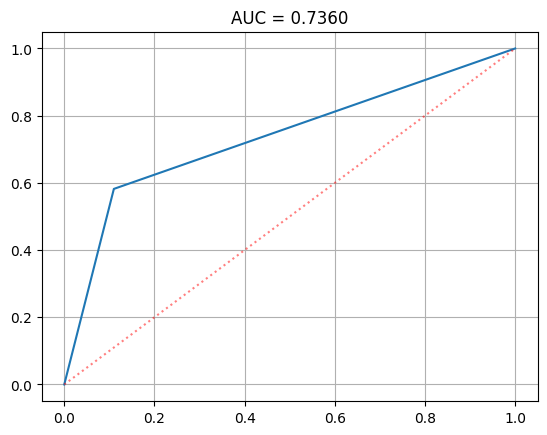

In [8]:
ras = roc_auc_score(ddf['Outcome'], ddf['예측결과'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(ddf['Outcome'], ddf['예측결과'])

plt.figure()
sb.lineplot(x = fpr, y = tpr)
sb.lineplot(x = [0,1], y = [0,1], color = 'red', linestyle = ':', alpha = 0.5)
plt.title('AUC = {:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [9]:
# 정확도
acc = accuracy_score(ddf['Outcome'], ddf['예측결과'])

# 정밀도
pre = precision_score(ddf['Outcome'], ddf['예측결과'])

# 재현율
recall = recall_score(ddf['Outcome'], ddf['예측결과'])

# F1 score
f1 = f1_score(ddf['Outcome'], ddf['예측결과'])

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'설명력(Pseudo-Rsqe)': [fit.prsquared], '정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

result_df.T      

,0
설명력(Pseudo-Rsqe),0.271810
정확도(Accuracy),0.782552
정밀도(Precision),0.739336
"재현율(Recall, TPR)",0.582090
"위양성율(Fallout, FPR)",0.110000
"특이성(Specificity, TNR)",0.890000
RAS,0.736045
f1_score,0.651357


In [28]:
coef = fit.params
coef

Intercept                  -8.404696
Pregnancies                 0.123182
Glucose                     0.035164
BloodPressure              -0.013296
SkinThickness               0.000619
Insulin                    -0.001192
BMI                         0.089701
DiabetesPedigreeFunction    0.945180
Age                         0.014869
dtype: float64

In [29]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate, columns= ['odds_rate'])
odds_rate_df

,odds_rate
Intercept,0.000224
Pregnancies,1.131091
Glucose,1.035789
BloodPressure,0.986792
SkinThickness,1.000619
Insulin,0.998809
BMI,1.093847
DiabetesPedigreeFunction,2.573276
Age,1.014980


# 문제 2.

  - 다음의 데이터는 타이타닉 탑승객 명단 데이터이다. 적절한 데이터 전처리와 정제를 수행한 후 분석하라.

  - 단, 모든 독립변수는 정규분포를 만족한다고 가정한다.

| 변수명 | 설명 |
|---|---|
| PassengerId | 탑승객의 ID(인덱스와 같은 개념) |
|Survived| 생존유무(0은 사망 1은 생존) |
| Pclass | 객실의 등급 |
| Name | 이름 |
| Sex | 성별 |
| SibSp | 동승한 형제 혹은 배우자의 수 |
| Parch | 동승한 자녀 혹은 부모의 수 |
| Ticket | 티켓번호 |
| Fare | 요금 |
| Cabin |	선실 |
| Embarked | 탑승지 (C = Cherbourg, Q = Queenstown, S = Southampton) |


In [10]:
tf = read_excel('https://data.hossam.kr/E05/titanic.xlsx')
tf

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [11]:
tdf = tf.copy()
tf.drop(columns = ['Name', 'Ticket'], axis = 1, inplace = True)
tf.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


In [12]:
tf.replace({"Sex": "male"}, 0, inplace=True)
tf.replace({"Sex": "female"}, 1, inplace=True)
tf.replace({"Embarked": "C"}, 0, inplace=True)
tf.replace({"Embarked": "Q"}, 1, inplace=True)
tf.replace({"Embarked": "S"}, 2, inplace=True)
tf

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,NaN,2.0
1,2,1,1,1,38.0,1,0,71.2833,C85,0.0
2,3,1,3,1,26.0,0,0,7.9250,NaN,2.0
3,4,1,1,1,35.0,1,0,53.1000,C123,2.0
4,5,0,3,0,35.0,0,0,8.0500,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,NaN,2.0
887,888,1,1,1,19.0,0,0,30.0000,B42,2.0
888,889,0,3,1,NaN,1,2,23.4500,NaN,2.0
889,890,1,1,0,26.0,0,0,30.0000,C148,0.0


In [13]:
tf.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin           object
Embarked       float64
dtype: object

In [14]:
tf['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [21]:
tf['Cabin'] = tf['Cabin'].str[:1]
tf['Cabin'] = tf['Cabin'].fillna(0)
tf.replace({"Cabin": "A"}, 1, inplace=True)
tf.replace({"Cabin": "B"}, 2, inplace=True)
tf.replace({"Cabin": "C"}, 3, inplace=True)
tf.replace({"Cabin": "D"}, 4, inplace=True)
tf.replace({"Cabin": "E"}, 5, inplace=True)
tf.replace({"Cabin": "F"}, 6, inplace=True)
tf.replace({"Cabin": "G"}, 7, inplace=True)
tf.replace({"Cabin": "T"}, 8, inplace=True)
tf

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0,2
1,2,1,1,1,38.0,1,0,71.2833,3,0
2,3,1,3,1,26.0,0,0,7.9250,0,2
3,4,1,1,1,35.0,1,0,53.1000,3,2
4,5,0,3,0,35.0,0,0,8.0500,0,2
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0,2
887,888,1,1,1,19.0,0,0,30.0000,2,2
888,889,0,3,1,NaN,1,2,23.4500,0,2
889,890,1,1,0,26.0,0,0,30.0000,3,0


In [26]:
tf['Embarked'] = tf['Embarked'].fillna(3).astype('int').replace({3: None}) # 결측치를 3으로 바꾸고 data type을 int로 변경
tf

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0,2
1,2,1,1,1,38.0,1,0,71.2833,3,0
2,3,1,3,1,26.0,0,0,7.9250,0,2
3,4,1,1,1,35.0,1,0,53.1000,3,2
4,5,0,3,0,35.0,0,0,8.0500,0,2
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0,2
887,888,1,1,1,19.0,0,0,30.0000,2,2
888,889,0,3,1,NaN,1,2,23.4500,0,2
889,890,1,1,0,26.0,0,0,30.0000,3,0


In [ ]:
empty = tf.isnull().value_counts
empty